# Imports

In [1]:
from fastai import *
from fastai.text import *

%matplotlib inline

In [2]:
%reload_ext autoreload
%autoreload 2

### Tokenization

The first step of processing we make texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

To see what the tokenizer had done behind the scenes, let's have a look at a few texts in a batch.

The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like his: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unkown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at list twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

The correspondance from ids tokens is stored in the `vocab` attribute of our datasets, in a dictionary called `itos` (for int to string).

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the variaous arguments to pass will appear in the step they're revelant, so it'll be more readable.

Now let's grab the full dataset for what follows.

In [3]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jupyter/.fastai/data/imdb/README'),
 PosixPath('/home/jupyter/.fastai/data/imdb/test'),
 PosixPath('/home/jupyter/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train'),
 PosixPath('/home/jupyter/.fastai/data/imdb/models')]

In [4]:
(path / 'train').ls()

[PosixPath('/home/jupyter/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/neg'),
 PosixPath('/home/jupyter/.fastai/data/imdb/train/unsup')]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder in `train` that contains the unlabelled data.

## Language model

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipeia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviex lefts by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust a little bit the parameters of our model. Plus there might be some words extremely common in that dataset that were barely present in wikipedia, and therefore might no be part of the vocabulary the model was trained on.

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [5]:
BS=48
data_lm = (TextList.from_folder(path)                           
           # Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test']) 
           # We may have other temp folders that contain text
           # files so we only keep what's in train and test
            .random_split_by_pct(0.1)
           # We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           # We want to do a language model so we label accordingly
            .databunch(bs=BS))
data_lm.save('tmp_lm')

In [7]:
len(data_lm.train_ds), len(data_lm.valid_ds)

(90000, 10000)

Here we are using both training and test texts in training the language model since we are not using the labels. This will allow us to acces to more data than just training texts.

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [5]:
BS=42
data_lm = TextLMDataBunch.load(path, 'tmp_lm', bs=BS)

In [6]:
data_lm.show_batch()

idx,text
0,"xxbos xxmaj lackawanna xxmaj blues is a touching story about xxmaj nanny , a woman who gives all of herself to help those in need . xxmaj it 's told from the viewpoint of a boy , taken in by xxmaj nanny when his own mother is n't quite up to the task . \n\n i have respect for this movie for three main reasons : 1 ) xxmaj it is touching , but not sappy . xxmaj it 's told in a very real fashion , without a lot of the aggravating xxmaj hollywood"
1,"and returns , but delayed . xxmaj he gets unnerved watching xxmaj angela speaking to a mysterious man in sunglasses , who seems to be watching the passengers leave the plane , asks who it was- and she denies having spoken to anyone . xxmaj she is also unaware the plane was "" delayed and missing "" . xxmaj she begins acting strangely and having odd meetings with unknown people , and as the reporter begins to investigate things and ask more questions , she tries to kill him and he finds she 's now"
2,"then there 's xxmaj washington to bring a smile to your face . xxmaj watch this film , you wo n't be disappointed xxbos i had to review this film here , as terrible as it is , just because all of the other reviews were positive . xxmaj this movie is positive , positively terrible . i saw it in 87 and loathed it then , and i 'm absolutely sure that it is just as bad now . xxmaj bad acting , bad jokes , bad premise . xxmaj not funny . i"
3,"my favorite character in all the xxmaj dexter series would most definitely have to be xxmaj dean xxmaj higgins , i love his voice and hearing him get upset especially seeing his expression at the end was just pure hysterical for me . xxbos xxmaj the number one reason i went to see this show was because of the actresses :-) xxmaj and they .. ahem i mean it did n't disappoint . xxmaj so xxmaj close is in essence xxmaj charlie 's xxmaj angels meets xxmaj the xxmaj matrix in my opinion . xxmaj"
4,"about in front . xxmaj tom xxmaj conway as the xxmaj falcon looked as handsome and debonair as ever ( no . 9 / 13  i do n't count those last 3 non- xxup rko efforts with xxmaj john xxmaj calvert ) , and had to do without the comedy double act of xxmaj clark and xxmaj gargan from now on . \n\n xxmaj investigation of a painting painted by a dead man ( with an art gallery eerily similar to the one in xxmaj woman xxmaj in xxmaj the xxmaj window ) leads"
5,"great is it has all that , but it 's not pretentiously "" arty , "" either . xxmaj it 's just a real charmer . xxbos xxmaj here i begin my attempt to once and for all write my imdb comment for each and every episode of probably my favourite tv show of all - time . i had already submitted some ( xxmaj seasons 9 , 10 and 11 are done ) but from now on i will write in order ( with the exception of course of the up - coming 7"
6,"called xxup billy xxup two xxup hats . i apologize . i should n't really because only 4 people came on the two nights it showed . xxup billy xxup two xxup hats featured xxmaj desi xxmaj arnaz xxmaj jnr as an xxmaj indian . xxmaj it was filmed in xxmaj israel . xxmaj maybe xxmaj desi xxmaj jnr was making this in between takes of this glorious musical nobody saw either , called xxup marco about xxrep 5 . xxmaj marco xxmaj polo . i am just aghast at all this . xxmaj anyway"
7,"that 's reality , but art provides the opportunity to inject more of her story and her relationship with j.w. into the film . xxmaj that opportunity is missed . xxmaj we do learn some more about j.w. 's family as the film progresses , but there 's no closure on his mom - and - pop issues , although i suppose one could argue that the lack of parental comfort has something to do with the end of the movie . \n\n xxmaj robertson the actor is pretty darned good in this film ,"
8,"complex and the variety is immense - so it is understandable that fitting all this into 90 minutes borders with the impossible . xxmaj yet it is obvious that the author is more knowledgeable about heavy metal than the recent developments in th

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in './fastai/models/' (or elsewhere if you specified different paths in your config file).

In [7]:
learn = language_model_learner(data_lm, pretrained_model=URLs.WT103, drop_mult=0.3)

In [7]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


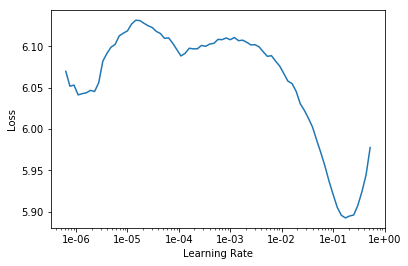

In [8]:
learn.recorder.plot(skip_end=15)

In [11]:
learn.fit_one_cycle(1, 1e-2, moms=(0.8,0.7))

Total time: 53:32
epoch  train_loss  valid_loss  accuracy
1      4.437583    4.257309    0.275153  (53:32)



In [12]:
learn.save('fit_head')

In [14]:
ls /home/jupyter/.fastai/data/imdb/models/

fit_head.pth  tmp.pth


In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7))

Total time: 2:22:17
epoch  train_loss  valid_loss  accuracy
1      4.307920    4.245430    0.271067  (14:14)
2      4.253745    4.162714    0.281017  (14:13)
3      4.166390    4.114120    0.287092  (14:14)
4      4.099329    4.068735    0.292060  (14:10)
5      4.048801    4.035339    0.295645  (14:12)
6      3.980410    4.009860    0.298551  (14:12)
7      3.947437    3.991286    0.300850  (14:14)
8      3.897383    3.977569    0.302463  (14:15)
9      3.866736    3.972447    0.303147  (14:14)
10     3.847952    3.972852    0.303105  (14:15)



In [ ]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [ ]:
learn.predict('I liked this movie because ', 100, temperature=1.1, min_p=0.001)

Total time: 00:10



'I liked this movie because  of course after yeah funny later that the world reason settings - the movie that perfect the kill of the same plot - a mention of the most of course . do xxup diamonds and the " xxup disappeared kill of course and the movie niece , from the care more the story of the let character , " i was a lot \'s the little performance is not only . the excellent for the most of course , with the minutes night on the into movies ( ! , in the movie its the first ever ! \n\n a'

We have to save the model but also it's encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [8]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

[PosixPath('/home/jhoward/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/home/jhoward/.fastai/data/imdb/models'),
 PosixPath('/home/jhoward/.fastai/data/imdb/tmp_lm'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train'),
 PosixPath('/home/jhoward/.fastai/data/imdb/test'),
 PosixPath('/home/jhoward/.fastai/data/imdb/README'),
 PosixPath('/home/jhoward/.fastai/data/imdb/tmp_clas')]

In [ ]:
(path / 'train').ls()

[PosixPath('/home/jhoward/.fastai/data/imdb/train/pos'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/unsup'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/unsupBow.feat'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/labeledBow.feat'),
 PosixPath('/home/jhoward/.fastai/data/imdb/train/neg')]

Make sure the vocab used in the classifier is the same vocab used in the language model.

In [12]:
from fastai.utils import *
show_install()



```text
=== Software === 
python version  : 3.6.5
fastai version  : 1.0.28
torch version   : 1.0.0.dev20181024
nvidia driver   : 396.44
torch cuda ver  : 9.2.148
torch cuda is   : available
torch cudnn ver : 7104
torch cudnn is  : enabled

=== Hardware === 
nvidia gpus     : 1
torch available : 1
  - gpu0        : 7611MB | Tesla P4

=== Environment === 
platform        : Linux-4.9.0-8-amd64-x86_64-with-debian-9.5
distro          : #1 SMP Debian 4.9.110-3+deb9u6 (2018-10-08)
conda env       : Unknown
python          : /opt/anaconda3/bin/python
sys.path        : 
/opt/anaconda3/lib/python36.zip
/opt/anaconda3/lib/python3.6
/opt/anaconda3/lib/python3.6/lib-dynload
/opt/anaconda3/lib/python3.6/site-packages
/opt/anaconda3/lib/python3.6/site-packages/IPython/extensions
/home/jupyter/.ipython
```

Please make sure to include opening/closing ``` when you paste into forums/github to make the reports appear formatted as code sections.

Optional package(s) to enhance the diagnostics can be ins

In [9]:
data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #remove docs with labels not in above list (i.e. 'unsup')
             .filter_missing_y()
             #label them all with their folders
             .databunch(bs=BS))
data_clas.save('tmp_clas')

TypeError: 'bool' object is not callable

In [ ]:
len(data_clas.train_ds)

75000

In [ ]:
data_clas = TextClasDataBunch.load(path, 'tmp_clas', bs=BS)
data_clas.show_batch()

text,label
"xxfld 1 match 1 : tag team table match bubba ray and spike dudley vs eddie guerrero and chris benoit bubba ray and spike dudley started things off with a tag team table match against eddie guerrero and chris benoit . according to the rules of the match , both",pos
"xxfld 1 i have never seen any of spike lee 's prior films , as their trailers never caught my interest . i have seen , and admire denzel washington , and jodie foster 's work , and have several of their dvds . i was , however , entirely",neg
"xxfld 1 pier paolo pasolini , or pee - pee - pee as i prefer to call him ( due to his love of showing male genitals ) , is perhaps xxup the most overrated european marxist director - and they are thick on the ground . how anyone can",neg
"xxfld 1 chris rock deserves better than he gives himself in "" down to earth . "" as directed by brothers chris & paul weitz of "" american pie "" fame , this uninspired remake of warren beatty 's 1978 fantasy "" heaven can wait , "" itself a rehash",neg
"xxfld 1 yesterday , i went to the monthly antique flea market that comes to town . i really have no interest in such things , but i went for the fellowship of friends who do have such an interest . looking over the hundreds of vendor , passing many",pos


We can then create a model to classify those reviews and load the encoder we saved before.

In [ ]:
learn = text_classifier_learner(data_clas, drop_mult=0.5)
learn.load_encoder('fine_tuned_enc')
learn.freeze()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


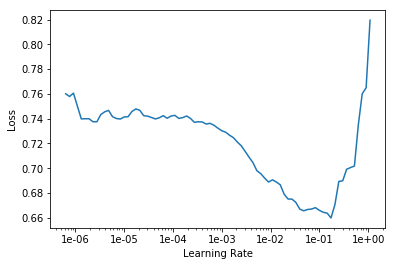

In [ ]:
learn.recorder.plot()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))

Total time: 02:46
epoch  train_loss  valid_loss  accuracy
1      0.294225    0.210385    0.918960  (02:46)



In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

Total time: 03:03
epoch  train_loss  valid_loss  accuracy
1      0.268781    0.180993    0.930760  (03:03)



In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

Total time: 04:06
epoch  train_loss  valid_loss  accuracy
1      0.211133    0.161494    0.941280  (04:06)



In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

Total time: 10:01
epoch  train_loss  valid_loss  accuracy
1      0.188145    0.155038    0.942480  (05:00)
2      0.159475    0.153531    0.944040  (05:01)



In [ ]:
learn.predict("I really loved that movie, it was awesome!")

('pos', tensor(0), tensor([[9.9999e-01, 1.1991e-05]]))